<a href="https://colab.research.google.com/github/aisha-partha/AIMLOps-MiniProjects/blob/main/M1_NB_MiniProject_1_Employee_Attrition_Prediction_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Programme in AI and MLOps
## A programme by IISc and TalentSprint
### Mini Project Notebook: Employee Attrition Prediction

## Problem Statement

To predict employee attrition using CatBoost and XgBoost

## Learning Objectives

At the end of the experiment, you will be able to

* explore the employee attrition dataset
* apply CatBoost and XgBoost on the dataset
* tune the model hyperparameters to improve accuracy
* evaluate the model using suitable metrics


## Introduction

Employee attrition is the gradual reduction in employee numbers. Employee attrition happens when the size of your workforce diminishes over time. This means that employees are leaving faster than they are hired. Employee attrition happens when employees retire, resign, or simply aren't replaced.
Although employee attrition can be company-wide, it may also be confined to specific parts of a business.

Employee attrition can happen for several reasons. These include unhappiness about employee benefits or the pay structure, a lack of employee development opportunities, and even poor conditions in the workplace.

To know more about the factors that lead to employee attrition, refer [here](https://www.betterup.com/blog/employee-attrition#:~:text=Employee%20attrition%20is%20the%20gradual,or%20simply%20aren't%20replaced).


**Gradient Boosted Decision Trees**

* Gradient boosted decision trees (GBDTs) are one of the most important machine learning models.

* GBDTs originate from AdaBoost, an algorithm that ensembles weak learners and uses the majority vote, weighted by their individual accuracy, to solve binary classification problems. The weak learners in this case are decision trees with a single split, called decision stumps.

* Some of the widely used gradient boosted decision trees are XgBoost, CatBoost and LightGBM.

## Dataset

The dataset used for this mini-project is [HR Employee Attrition dataset](https://data.world/aaizemberg/hr-employee-attrition). This dataset is synthetically created by IBM data scientists. There are 35 features and 1470 records.

There are numerical features such as:

* Age
* DistanceFromHome
* EmployeeNumber
* PerformanceRating

There are several categorical features such as:
* JobRole
* EducationField
* Department
* BusinessTravel

Dependent or target feature is 'attrition' which has values as Yes/No.

In [ ]:
#@title Download the data
!wget -qq https://cdn.iisc.talentsprint.com/CDS/Datasets/wa_fn_usec_hr_employee_attrition_tsv.csv
print("Data Downloaded Successfuly!!")

Data Downloaded Successfuly!!


## Grading = 10 Points

### Install Required Dependencies

In [ ]:
# Install CatBoost
!pip -qq install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 6.8 MB/s eta 0:00:00


### Import Required Packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, metrics
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
pd.set_option('display.max_columns', 100)
%matplotlib inline

Please refer to the [ReadMe](https://drive.google.com/file/d/1V5CAUlRwLNcQcIWfgCJhukYvRESi2cC2/view?usp=sharing) before proceeding further.

# Part-A

## Load the Dataset

**Exercise 1: Read the dataset [0.5 Mark]**

**Hint:** pd.read_csv()

In [76]:
# read the dataset
# YOUR CODE HERE

df_emp = pd.read_csv("/content/wa_fn_usec_hr_employee_attrition_tsv.csv")

In [77]:
# Check the shape of dataframe.
# YOUR CODE HERE

df_emp.shape

(1470, 35)

## Data Exploration

- Check for missing values
- Check for features having consistent data across samples
- Check for outliers or inconsistencies in data columns
- Check for correlated features
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships? Making correlation heatmaps makes it easy to identify possible collinearity

**Exercise 2: Create a `List` of numerical and categorical columns. Display a statistical description of the dataset. Remove missing values (if any) [0.5 Mark]**

**Hint:**
>Use `for` to iterate through each column.

>For statistical description display - samples count, missing values count, range, and data type of each feature.

In [78]:
cat_cols = list(df_emp.select_dtypes(exclude=[np.number]).columns)
num_cols = list(df_emp.select_dtypes(include=[np.number]).columns)

print('Number of categorical columns: ', len(cat_cols))
print('Categorical columns: ', cat_cols)
print('Number of numeric columns:', len(num_cols))
print('Numeric columns: ', num_cols)



Number of categorical columns:  9
Categorical columns:  ['attrition', 'businesstravel', 'department', 'educationfield', 'gender', 'jobrole', 'maritalstatus', 'over18', 'overtime']
Number of numeric columns: 26
Numeric columns:  ['age', 'dailyrate', 'distancefromhome', 'education', 'employeecount', 'employeenumber', 'environmentsatisfaction', 'hourlyrate', 'jobinvolvement', 'joblevel', 'jobsatisfaction', 'monthlyincome', 'monthlyrate', 'numcompaniesworked', 'percentsalaryhike', 'performancerating', 'relationshipsatisfaction', 'standardhours', 'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear', 'worklifebalance', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']


#### Note
stats_df dataframe captures the statictical description.

For numerical and categorical features, we have captured
    - the samples count in each feature
    - the missing values count in each feature
    - the data type for each feature

For range information,
- In numerical columns, we have captured the minimum, maximum value and range (difference between the maximum and minimum)
- In categorical columns we have captured the most frequently occuring class in the feature. Please note, metrics like max and min value are not applicable in categorical, hence, we have populated with np.NaN.

We have captured the unique classes in each categorical feature in seperate df called feature_wise_unique_categories.

In [ ]:
col_stats_info = []
unique_cat_info = []

for col in df_emp.columns:
    stats_dict = dict()
    cat_uniq_values_dict = dict()
    stats_dict['column_name'] = col
    stats_dict['samples_count'] = df_emp[col].count()
    stats_dict['missing_val_count'] = df_emp[col].isna().sum()
    if df_emp[col].dtype != 'object':
        stats_dict['col_range'] = df_emp[col].max() - df_emp[col].min()
        stats_dict['max_value'] = df_emp[col].max()
        stats_dict['min_value'] = df_emp[col].min()
    else:
        stats_dict['col_range'] = np.nan
        stats_dict['modal_class'] = df_emp[col].mode()[0]
        stats_dict['num_of_classes'] = df_emp[col].nunique()
        cat_uniq_values_dict['column_name'] = col
        cat_uniq_values_dict['classes'] = df_emp[col].unique()
    stats_dict['col_dtype'] = df_emp[col].dtype

    col_stats_info.append(stats_dict)
    unique_cat_info.append(cat_uniq_values_dict)


stats_df = pd.DataFrame.from_dict(col_stats_info)
stats_df



column_name  samples_count  missing_val_count  col_range  \
0                        age           1470                  0       42.0   
1                  attrition           1470                  0        NaN   
2             businesstravel           1470                  0        NaN   
3                  dailyrate           1470                  0     1397.0   
4                 department           1470                  0        NaN   
5           distancefromhome           1470                  0       28.0   
6                  education           1470                  0        4.0   
7             educationfield           1470                  0        NaN   
8              employeecount           1470                  0        0.0   
9             employeenumber           1470                  0     2067.0   
10   environmentsatisfaction           1470                  0        3.0   
11                    gender           1470                  0        NaN   
12                hourlyrate           1470                  0       70.0   
13            jobinvolvement           1470                  0        3.0   
14                  joblevel           1470                  0        4.0   
15                   jobrole           1470                  0        NaN   
16           jobsatisfaction           1470                  0        3.0   
17             maritalstatus           1470                  0        NaN   
18             monthlyincome           1470                  0    18990.0   
19               monthlyrate           1470                  0    24905.0   
20        numcompaniesworked           1470                  0        9.0   
21                    over18           1470                  0        NaN   
22                  overtime           1470                  0        NaN   
23         percentsalaryhike           1470                  0       14.0   
24         performancerating           1470                  0        1.0   
25  relationshipsatisfaction           1470                  0        3.0   
26             standardhours           1470                  0        0.0   
27          stockoptionlevel           1470                  0        3.0   
28         totalworkingyears           1470                  0       40.0   
29     trainingtimeslastyear           1470                  0        6.0   
30           worklifebalance           1470                  0        3.0   
31            yearsatcompany           1470                  0       40.0   
32        yearsincurrentrole           1470                  0       18.0   
33   yearssincelastpromotion           1470                  0       15.0   
34      yearswithcurrmanager           1470                  0       17.0   

    max_value  min_value col_dtype             modal_class  num_of_classes  
0        60.0       18.0     int64                     NaN             NaN  
1         NaN        NaN    object                      No             2.0  
2         NaN        NaN    object           Travel_Rarely             3.0  
3      1499.0      102.0     int64                     NaN             NaN  
4         NaN        NaN    object  Research & Development             3.0  
5        29.0        1.0     int64                     NaN             NaN  
6         5.0        1.0     int64                     NaN             NaN  
7         NaN        NaN    object           Life Sciences             6.0  
8         1.0        1.0     int64                     NaN             NaN  
9      2068.0        1.0     int64                     NaN             NaN  
10        4.0        1.0     int64                     NaN             NaN  
11        NaN        NaN    object                    Male             2.0  
12      100.0       30.0     int64                     NaN             NaN  
13        4.0        1.0     int64                     NaN             NaN  
14        5.0        1.0     int64                     NaN             NaN  
15        Na

In [ ]:
feature_wise_unique_categories = pd.DataFrame.from_dict(unique_cat_info).dropna()
feature_wise_unique_categories

column_name                                            classes
1        attrition                                          [Yes, No]
2   businesstravel     [Travel_Rarely, Travel_Frequently, Non-Travel]
4       department   [Sales, Research & Development, Human Resources]
7   educationfield  [Life Sciences, Other, Medical, Marketing, Tec...
11          gender                                     [Female, Male]
15         jobrole  [Sales Executive, Research Scientist, Laborato...
17   maritalstatus                        [Single, Married, Divorced]
21          over18                                                [Y]
22        overtime                                          [Yes, No]

In [ ]:
df_emp.describe(include='all')

age attrition businesstravel    dailyrate  \
count   1470.000000      1470           1470  1470.000000   
unique          NaN         2              3          NaN   
top             NaN        No  Travel_Rarely          NaN   
freq            NaN      1233           1043          NaN   
mean      36.923810       NaN            NaN   802.485714   
std        9.135373       NaN            NaN   403.509100   
min       18.000000       NaN            NaN   102.000000   
25%       30.000000       NaN            NaN   465.000000   
50%       36.000000       NaN            NaN   802.000000   
75%       43.000000       NaN            NaN  1157.000000   
max       60.000000       NaN            NaN  1499.000000   

                    department  distancefromhome    education educationfield  \
count                     1470       1470.000000  1470.000000           1470   
unique                       3               NaN          NaN              6   
top     Research & Development               NaN          NaN  Life Sciences   
freq                       961               NaN          NaN            606   
mean                       NaN          9.192517     2.912925            NaN   
std                        NaN          8.106864     1.024165            NaN   
min                        NaN          1.000000     1.000000            NaN   
25%                        NaN          2.000000     2.000000            NaN   
50%                        NaN          7.000000     3.000000            NaN   
75%                        NaN         14.000000     4.000000            NaN   
max                        NaN         29.000000     5.000000            NaN   

        employeecount  employeenumber  environmentsatisfaction gender  \
count          1470.0     1470.000000              1470.000000   1470   
unique            NaN             NaN                      NaN      2   
top               NaN             NaN                      NaN   Male   
freq              NaN             NaN                      NaN    882   
mean              1.0     1024.865306                 2.721769    NaN   
std               0.0      602.024335                 1.093082    NaN   
min               1.0        1.000000                 1.000000    NaN   
25%               1.0      491.250000                 2.000000    NaN   
50%               1.0     1020.500000                 3.000000    NaN   
75%               1.0     1555.750000                 4.000000    NaN   
max               1.0     2068.000000                 4.000000    NaN   

         hourlyrate  jobinvolvement     joblevel          jobrole  \
count   1470.000000     1470.000000  1470.000000             1470   
unique          NaN             NaN          NaN                9   
top             NaN             NaN          NaN  Sales Executive   
freq            NaN             NaN          NaN              326   
mean      65.891156        2.729932     2.063946              NaN   
std       20.329428        0.711561     1.106940              NaN   
min       30.000000        1.000000     1.000000              NaN   
25%       48.000000        2.000000     1.000000              NaN   
50%       66.000000        3.000000     2.000000              NaN   
75%       83.750000        3.000000     3.000000              NaN   
max      100.000000        4.000000     5.000000              NaN   

        jobsatisfaction maritalstatus  monthlyincome   monthlyrate  \
count       1470.000000          1470    1470.000000   1470.000000   
unique              NaN             3            NaN           NaN   
top                 NaN       Married            NaN           NaN   
freq                NaN           673            NaN           NaN   
mean           2.728571           NaN    6502.931293  14313.103401   
std            1.102846           NaN    4707.956783   7117.786044   
min            1.000000           NaN    1009.000000   2094.000000   
25%            2.000000           NaN    2911.000000   8

In [ ]:
df_emp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   age                       1470 non-null   int64 
 1   attrition                 1470 non-null   object
 2   businesstravel            1470 non-null   object
 3   dailyrate                 1470 non-null   int64 
 4   department                1470 non-null   object
 5   distancefromhome          1470 non-null   int64 
 6   education                 1470 non-null   int64 
 7   educationfield            1470 non-null   object
 8   employeecount             1470 non-null   int64 
 9   employeenumber            1470 non-null   int64 
 10  environmentsatisfaction   1470 non-null   int64 
 11  gender                    1470 non-null   object
 12  hourlyrate                1470 non-null   int64 
 13  jobinvolvement            1470 non-null   int64 
 14  joblevel                

First, we want to get a sense of our data:
- What features have the most divergent distributions based on target class
- Do we have a target label imbalance
- How our independent variables are distributed relative to our target label
- Are there features that have strong linear or monotonic relationships, making correlation heatmaps makes it easy to identify possible colinearity

### Check for outliers

**Exercise 3: Create a box plot to check for outliers [0.5 Mark]**

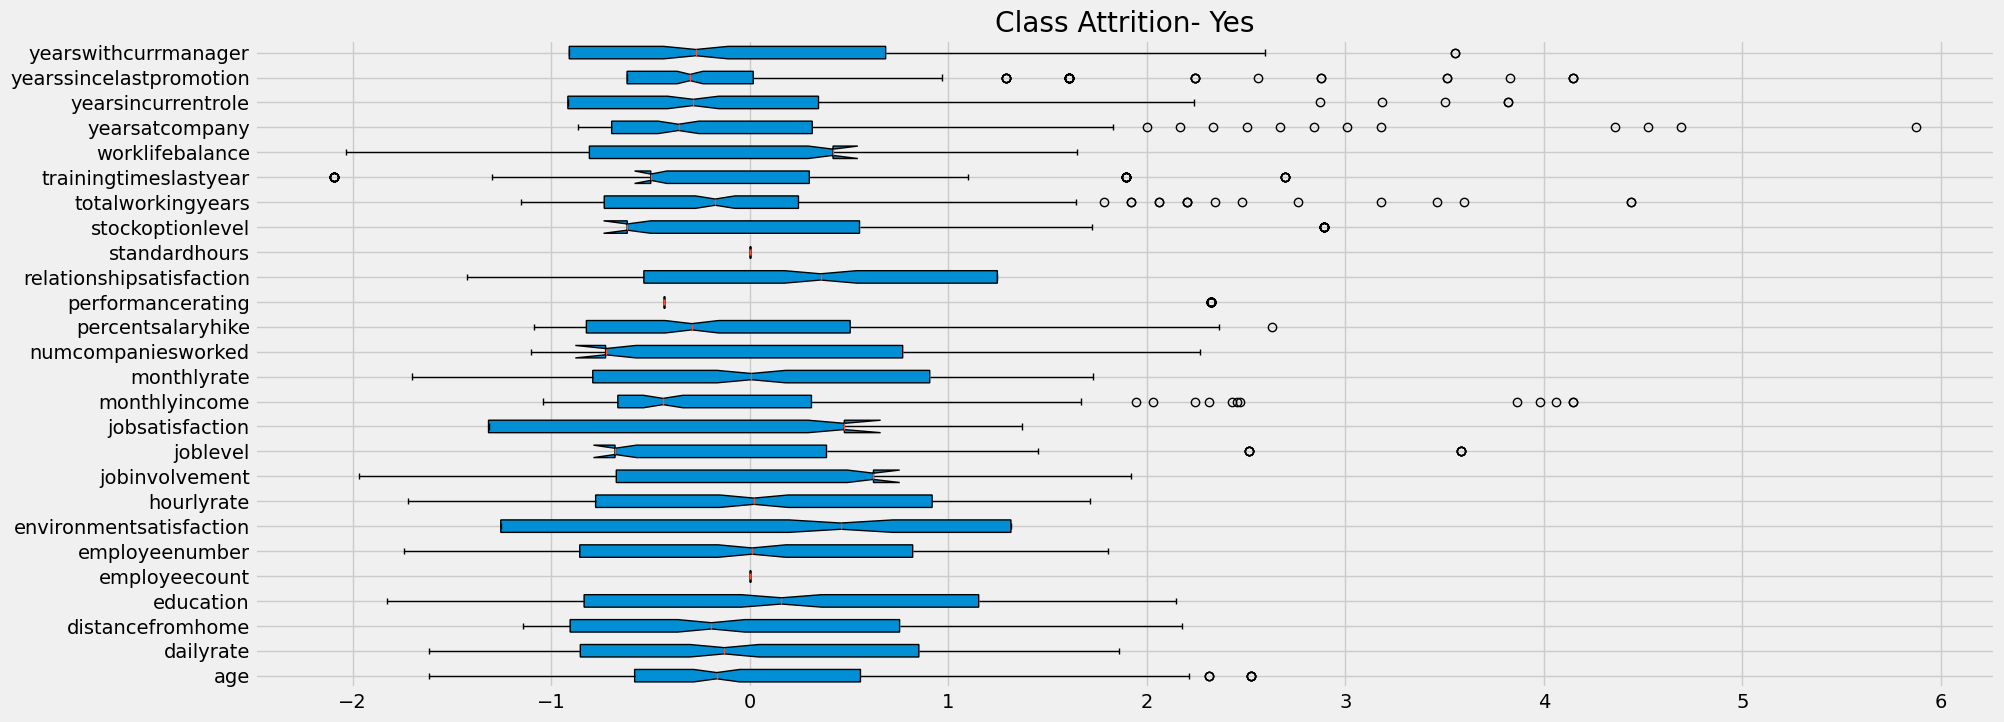

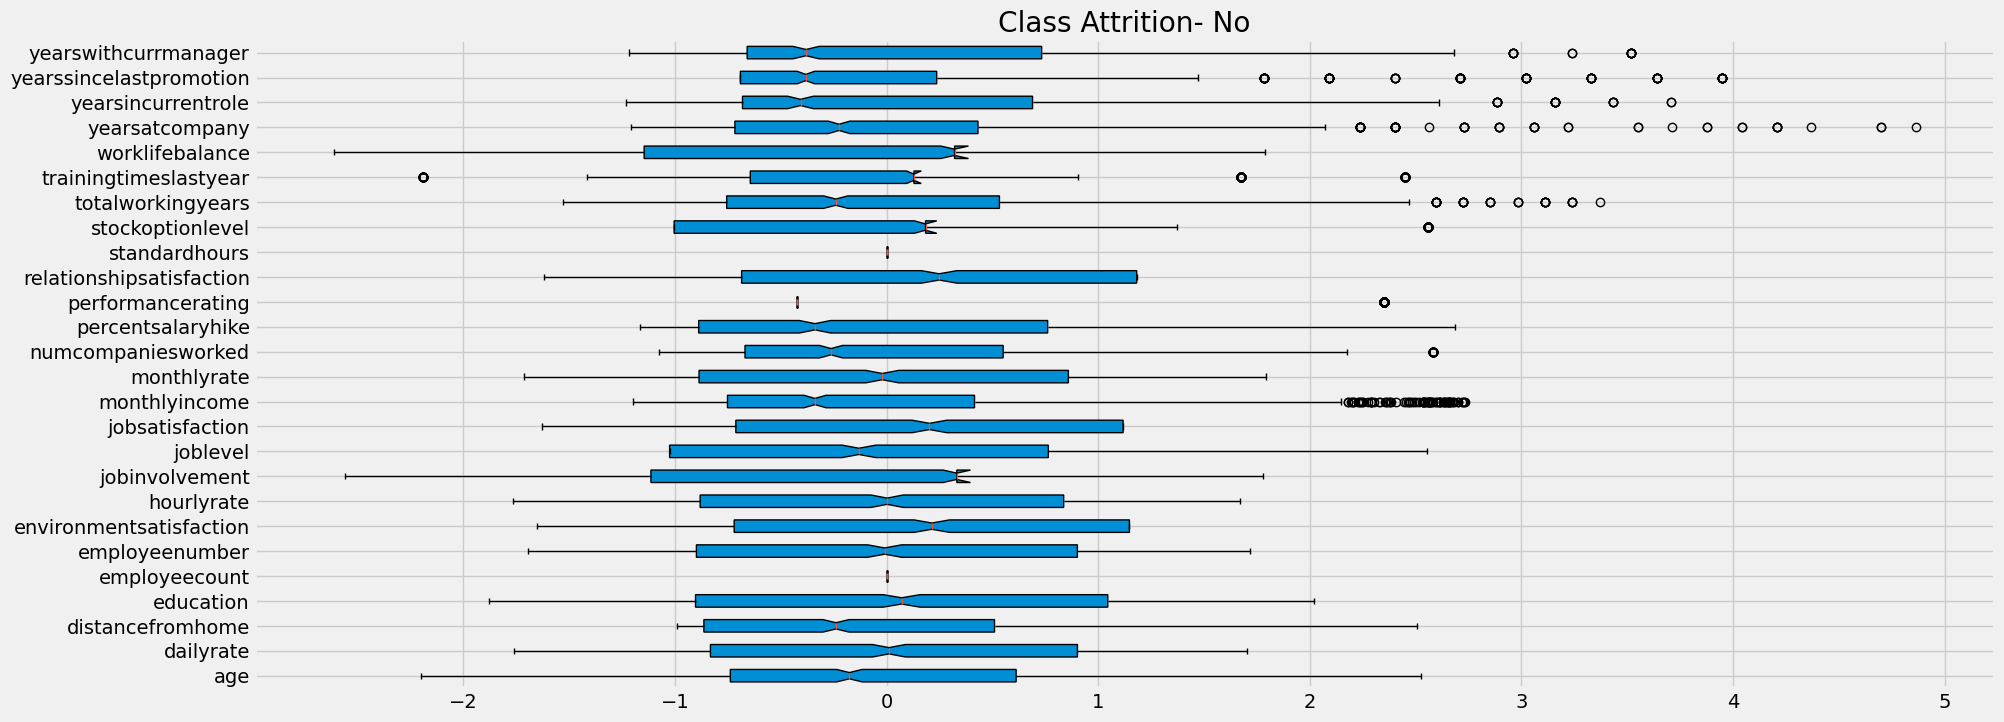

In [79]:
#F3
# Modify boxplots to show distributions against the target variable classes
# Apply standardization to plot on one graph
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
scale = StandardScaler()
ordinal = OrdinalEncoder()
df_emp['attrition'] = ordinal.fit_transform(df_emp[['attrition']])
df_yes = df_emp[df_emp['attrition'] == 1]
df_no = df_emp[df_emp['attrition'] == 0]
df_yes_numeric = df_yes.select_dtypes(include = 'number')
df_yes_numeric= df_yes_numeric.drop('attrition', axis = 1)
df_yes_numscaled = scale.fit_transform(df_yes_numeric)
df_no_numeric = df_no.select_dtypes(include = 'number')
df_no_numeric= df_no_numeric.drop('attrition', axis = 1)
df_no_numscaled = scale.fit_transform(df_no_numeric)

#Box Plot Version 1
figure1 = plt.figure(figsize =(20, 8))
figure2 = plt.figure(figsize =(20, 8))

ax1 = figure1.add_subplot(111)
ax2 = figure2.add_subplot(111)

bp1 = ax1.boxplot(df_yes_numscaled, patch_artist = True,notch ='True', vert = 0)
bp2 = ax2.boxplot(df_no_numscaled, patch_artist = True,notch ='True', vert = 0)

ax1.set_yticklabels(num_cols)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_title('Class Attrition- Yes')
ax2.set_title('Class Attrition- No')
ax2.set_yticklabels(num_cols)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()

plt.show()



<Axes: xlabel='attrition', ylabel='worklifebalance'>

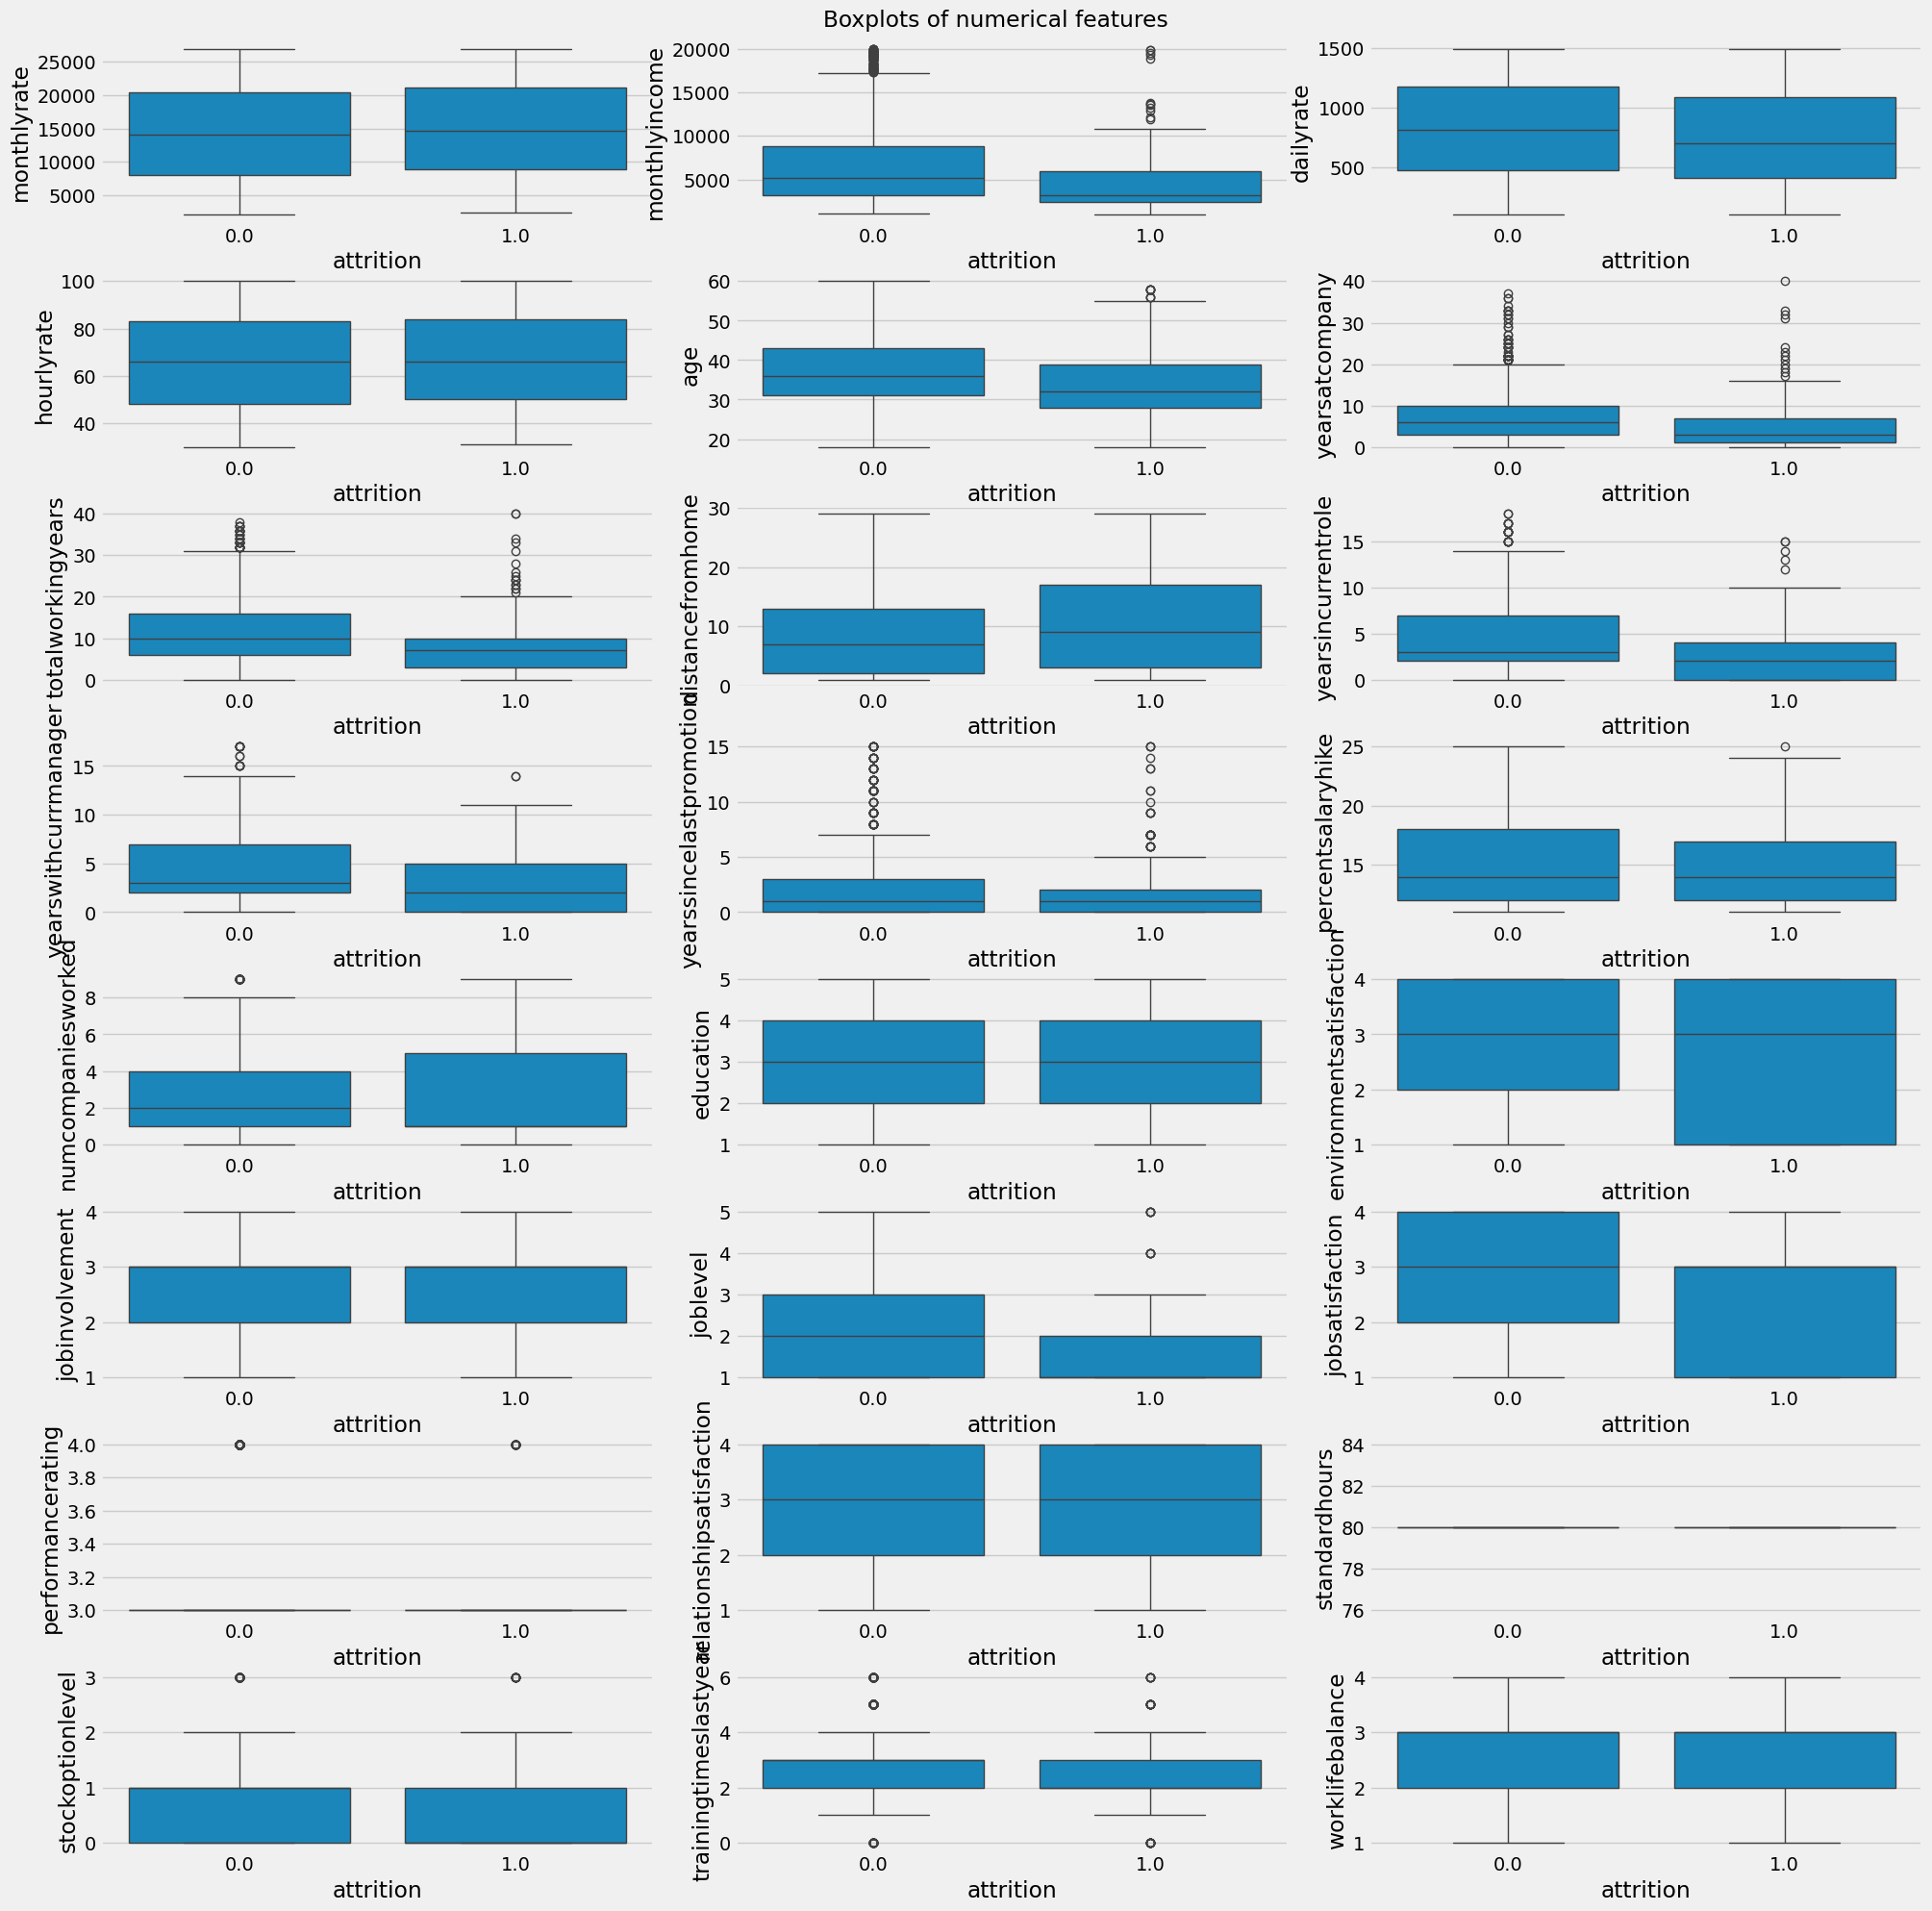

In [ ]:
fig, axes = plt.subplots(8,3,figsize=(20,20))
fig.suptitle('Boxplots of numerical features')
fig.tight_layout()
sns.set()


#Row 1
sns.boxplot(ax=axes[0, 0], data=df_emp, x='attrition', y='monthlyrate')
sns.boxplot(ax=axes[0, 1], data=df_emp, x='attrition', y='monthlyincome')
sns.boxplot(ax=axes[0, 2], data=df_emp, x='attrition', y='dailyrate')


#Row 2
sns.boxplot(ax=axes[1, 0], data=df_emp, x='attrition', y='hourlyrate')
sns.boxplot(ax=axes[1, 1], data=df_emp, x='attrition', y='age')
sns.boxplot(ax=axes[1, 2], data=df_emp, x='attrition', y='yearsatcompany')

#Row 3
sns.boxplot(ax=axes[2, 0], data=df_emp, x='attrition',y='totalworkingyears')
sns.boxplot(ax=axes[2, 1], data=df_emp, x='attrition',y='distancefromhome')
sns.boxplot(ax=axes[2, 2], data=df_emp, x='attrition',y='yearsincurrentrole')

#Row 4
sns.boxplot(ax=axes[3, 0], data=df_emp, x='attrition',y='yearswithcurrmanager')
sns.boxplot(ax=axes[3, 1], data=df_emp, x='attrition',y='yearssincelastpromotion')
sns.boxplot(ax=axes[3, 2], data=df_emp, x='attrition',y='percentsalaryhike')

#Row 5
sns.boxplot(ax=axes[4, 0], data=df_emp, x='attrition',y='numcompaniesworked')
sns.boxplot(ax=axes[4, 1], data=df_emp, x='attrition',y='education')
sns.boxplot(ax=axes[4, 2], data=df_emp, x='attrition',y='environmentsatisfaction')


#Row 6
sns.boxplot(ax=axes[5, 0], data=df_emp, x='attrition',y='jobinvolvement')
sns.boxplot(ax=axes[5, 1], data=df_emp, x='attrition',y='joblevel')
sns.boxplot(ax=axes[5, 2], data=df_emp, x='attrition',y='jobsatisfaction')


#Row 7
sns.boxplot(ax=axes[6, 0], data=df_emp, x='attrition',y='performancerating')
sns.boxplot(ax=axes[6, 1], data=df_emp, x='attrition',y='relationshipsatisfaction')
sns.boxplot(ax=axes[6, 2], data=df_emp, x='attrition',y='standardhours')


#Row 8
sns.boxplot(ax=axes[7, 0], data=df_emp, x='attrition',y='stockoptionlevel')
sns.boxplot(ax=axes[7, 1], data=df_emp, x='attrition',y='trainingtimeslastyear')
sns.boxplot(ax=axes[7, 2], data=df_emp, x='attrition',y='worklifebalance')



### Handling outliers

**Exercise 4: Use lower bound as 25% and upper bound as 75% to handle the outliers [0.5 Mark]**

In [80]:
df_emp_bkup = df_emp.copy()

1.We Have applied Lower Tail (Q1-1.5IQR) and Upper Tail(Q3+1.5IQR) as lower and Upper Bound respectively. While Q1 and Q3 gives spans only 50% of values, lower and upper bound spans - (mean +- 3 Sigma) -> thus spanning 99.6 percentile (considering variables are normally distributed)

2.Since Monthly Income has the most number of outliers, we have not removed them, rather capping the outliers to Upper_bound. Also, since there is no outlier towards ther lower tail of the variable, it is safe to say that attrition is not happening due to lower compensation. Also, most of the employees with higher compensation are not leaving the employer, and thus is not a major contributor to attrition. Therefore, we have applied capping to avoid loss of information from other variables.  


In [81]:

#F4
# Handle outliers - Further analysis on methods of handling outliers and their comparison
## Possibly avoid dropping rows

#### Add more comments on the boxplots and outlier observations
##### Identify if a sample is having outlier across all features
outlier_cols = ['yearswithcurrmanager', 'monthlyincome',  'numcompaniesworked', 'performancerating', 'stockoptionlevel', 'totalworkingyears', 'trainingtimeslastyear',  'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion']
s = set()
df_newemp = df_emp.copy()
for i in range(df_newemp.shape[1]):
  for column_name in outlier_cols:
    if column_name == df_newemp.columns[i]:
        q1 = df_newemp.iloc[:,i].quantile(0.25)
        q3 = df_newemp.iloc[:,i].quantile(0.75)
        iqr = q3-q1
        lower_tail = q1 - 1.5*iqr
        upper_tail = q3 + 1.5*iqr
        for j, element in enumerate(df_newemp[df_newemp.columns[i]]):
           if(df_newemp.columns[i] == 'monthlyincome'):
            if element > upper_tail:
             df_newemp[df_newemp.columns[i]][j]= upper_tail
            elif element < lower_tail:
             df_newemp[df_newemp.columns[i]][j]= lower_tail
           elif(element > upper_tail or element < lower_tail):
            s.add(j)
s = list(s)
df_outemp = df_newemp.iloc[s,:].copy()
df_newemp.drop(s,inplace=True)
df_newemp.shape


(812, 35)

In [82]:
print(df_emp.shape)
print(df_outemp.shape)
print(df_newemp.shape)

(1470, 35)
(658, 35)
(812, 35)


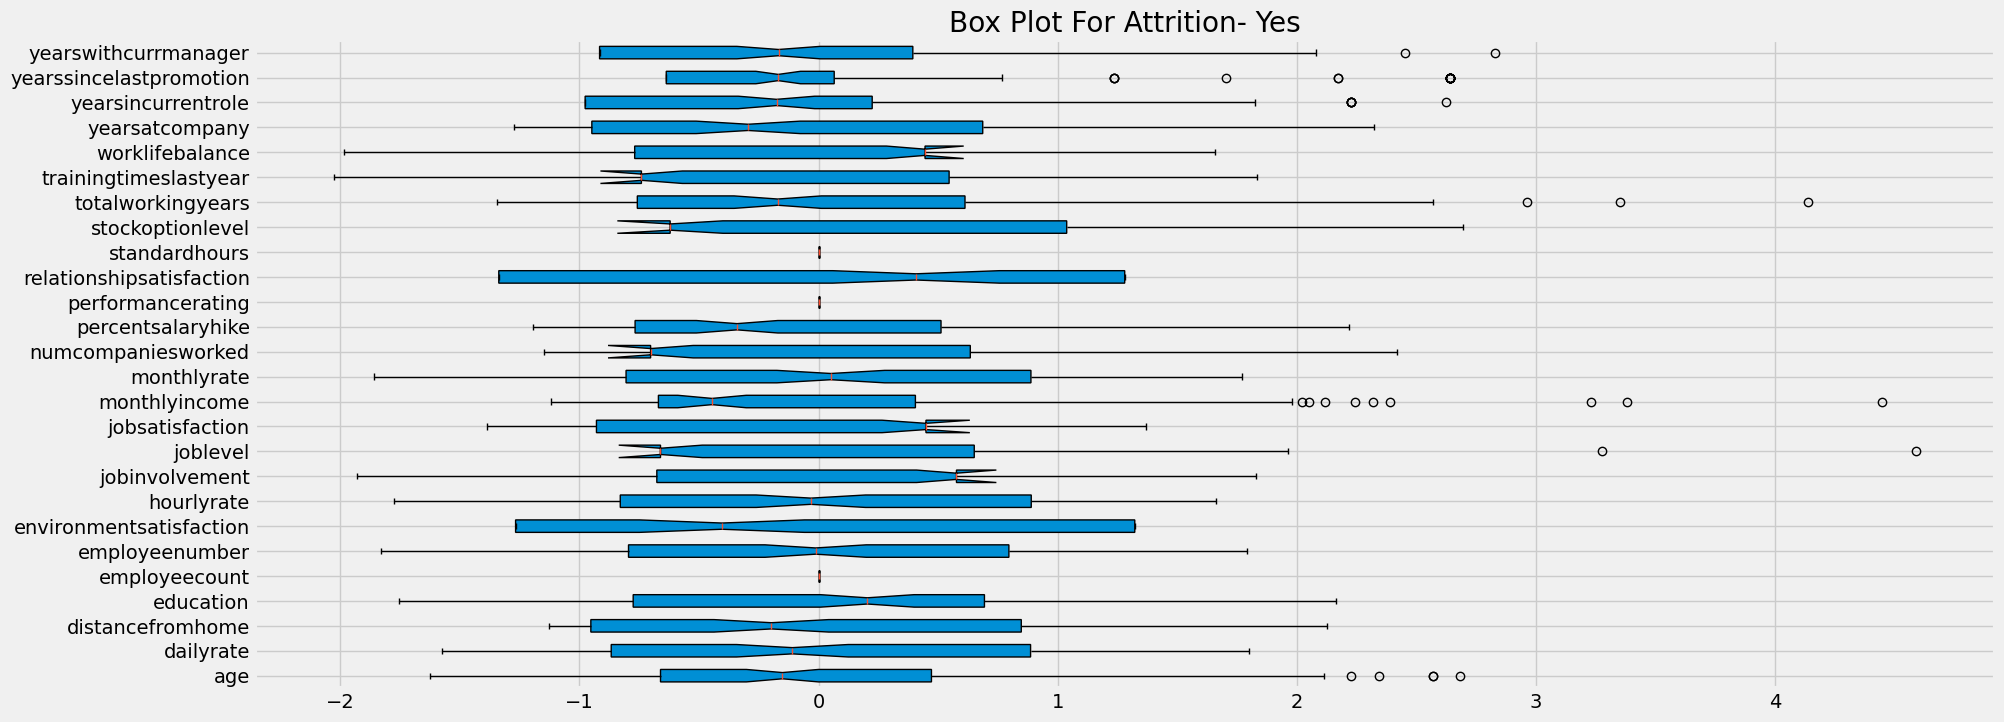

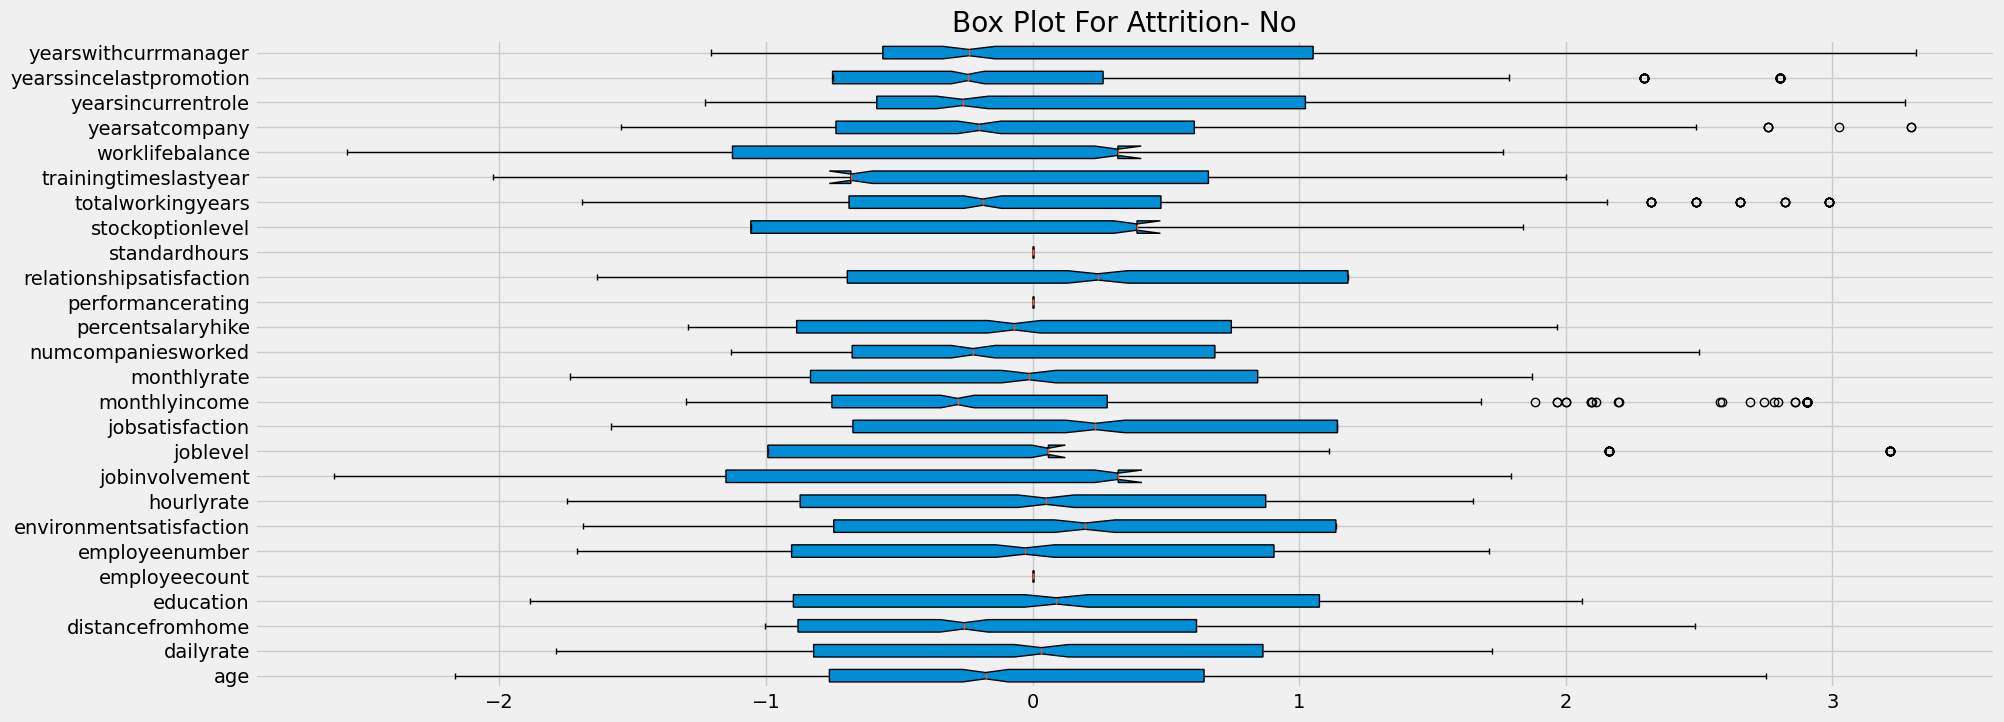

In [83]:
#Conolidated View - Recheck for Outliers
df_newemp['attrition'] = ordinal.fit_transform(df_newemp[['attrition']])
df_yes = df_newemp[df_emp['attrition'] == 1]
df_no = df_newemp[df_emp['attrition'] == 0]
df_yes_numeric = df_yes.select_dtypes(include = 'number')
df_yes_numeric= df_yes_numeric.drop('attrition', axis = 1)
df_yes_numscaled = scale.fit_transform(df_yes_numeric)
df_no_numeric = df_no.select_dtypes(include = 'number')
df_no_numeric= df_no_numeric.drop('attrition', axis = 1)
df_no_numscaled = scale.fit_transform(df_no_numeric)


# Recheck for outliers
# YOUR CODE HERE
figure1 = plt.figure(figsize =(20, 8))
figure2 = plt.figure(figsize =(20, 8))

ax1 = figure1.add_subplot(111)
ax2 = figure2.add_subplot(111)

bp1 = ax1.boxplot(df_yes_numscaled, patch_artist = True,notch ='True', vert = 0)
bp2 = ax2.boxplot(df_no_numscaled, patch_artist = True,notch ='True', vert = 0)

ax1.set_yticklabels(num_cols)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()
ax1.set_title('Box Plot For Attrition- Yes')
ax2.set_title('Box Plot For Attrition- No')
ax2.set_yticklabels(num_cols)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()

plt.show()

<Axes: xlabel='monthlyincome', ylabel='Count'>

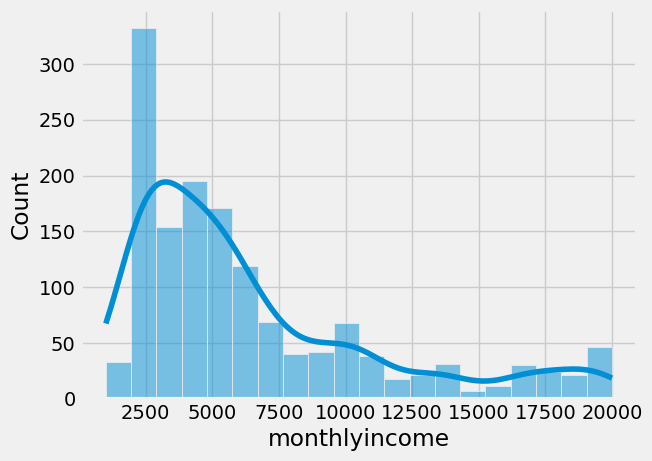

In [84]:
sns.histplot(data=df_emp, x = 'monthlyincome',kde=True )

Here to mute the effect of removal of Monthly Income, another approach is shown, which is binning the monthly variable, rather than capping it. The reduced dataframe has the same shape.

In [ ]:
#Alternative approach is to bin the monthly income

df_emp["monthlyincomecat"] = pd.cut(df_emp_bkup["monthlyincome"],
                                    bins = [0, 5000, 10000, 15000, 20000, np.inf],
                                    labels=[1,2,3,4,5])

<Axes: xlabel='monthlyincomecat'>

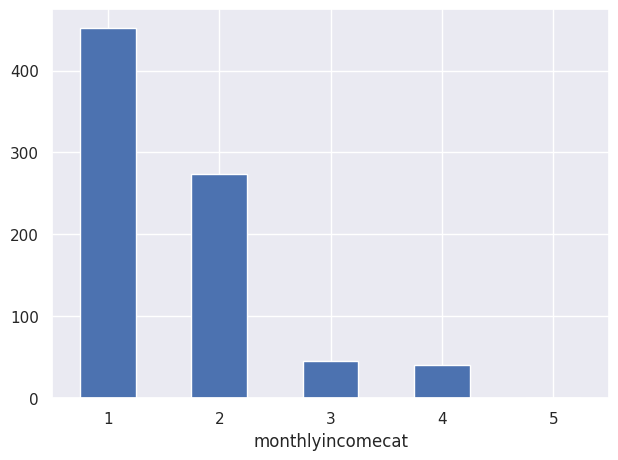

In [ ]:
df_emp["monthlyincomecat"].value_counts().sort_index().plot.bar(rot=0, grid=True)

### Target label imbalance

**Exercise 5: Check if there is an imbalance in target label [0.5 Mark]**

**Hint:** Use value_counts()

In [85]:
# Count of unique values in Attrition column
# YOUR CODE HERE
df_newemp['attrition'].value_counts()

attrition
0.0    673
1.0    139
Name: count, dtype: int64

<Axes: xlabel='attrition', ylabel='count'>

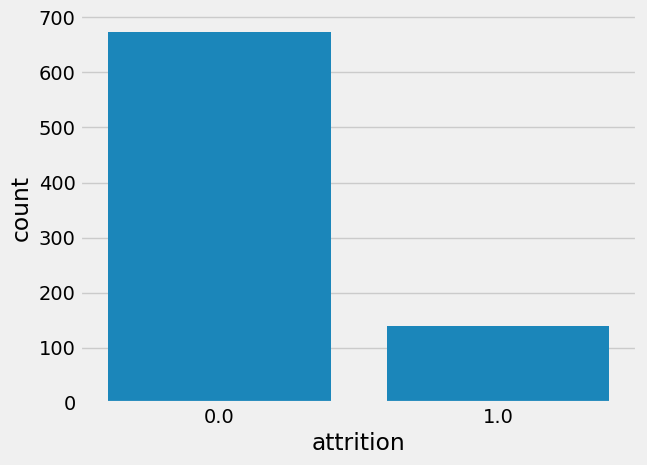

In [86]:
# Plot barplot to visualize balance/imbalance
# YOUR CODE HERE

sns.countplot(data=df_newemp, x='attrition')

If there is any imbalance in the dataset then a few techniques can be utilised (optional):
1. SMOTE
2. Cross Validation
3. Regularizing the model's parameters

### Downsampling of the majority target class

Mild imbalance seen in the target class. Post the test and train split of the data, we can apply downsampling on the train set to get a more balanced dataset using sklearn's resample. Avoided the downsampling here as it might cause data leakage. Below code is just for illustration purpose.



([<matplotlib.patches.Wedge at 0x7f9540a29d50>,
 [Text(-0.9618916732177651, 0.5336332157899547, '0.0'),
  Text(0.961891673217765, -0.5336332157899548, '1.0')],
 [Text(-0.5246681853915082, 0.29107266315815705, '83.9%'),
  Text(0.5246681853915082, -0.29107266315815716, '16.1%')])

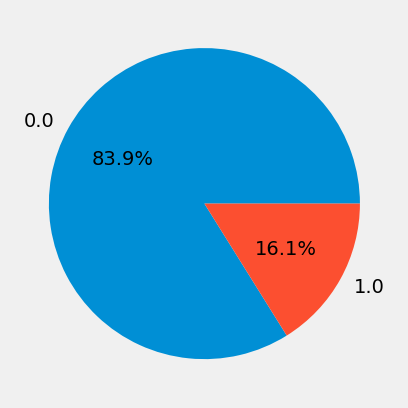

In [87]:
label=df_emp.attrition.value_counts().index
count=df_emp.attrition.value_counts().values
plt.pie(count,labels=label, autopct='%1.1f%%')

In [88]:
from sklearn.utils import resample
attrition_downsample = resample(df_emp[df_emp['attrition'] == 0],
             replace=True,
             n_samples=300,
             random_state=42)

print(attrition_downsample.shape)

(300, 35)


([<matplotlib.patches.Wedge at 0x7f9540a5bd00>,
 [Text(-0.2015662163437928, 1.0813746161385738, '0.0'),
  Text(0.2015661150981929, -1.0813746350105602, '1.0')],
 [Text(-0.10994520891479606, 0.5898406997119492, '55.9%'),
  Text(0.10994515368992339, -0.58984071000576, '44.1%')])

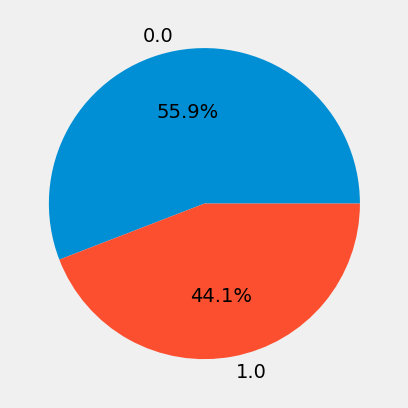

In [89]:
df_minority = df_emp[df_emp['attrition']==1]
df_emp_demo = pd.concat([attrition_downsample, df_minority])
label=df_emp_demo.attrition.value_counts().index
count=df_emp_demo.attrition.value_counts().values
plt.pie(count,labels=label, autopct='%1.1f%%')

###Plot pairplot

In [ ]:
#F6 - How to identify relevant features for pairplots ?


**Exercise 6: Visualize the relationships between the predictor variables and the target variable using a pairplot [0.5 Mark]**

**Hint:** Use sns.pairplot

From the Code Below

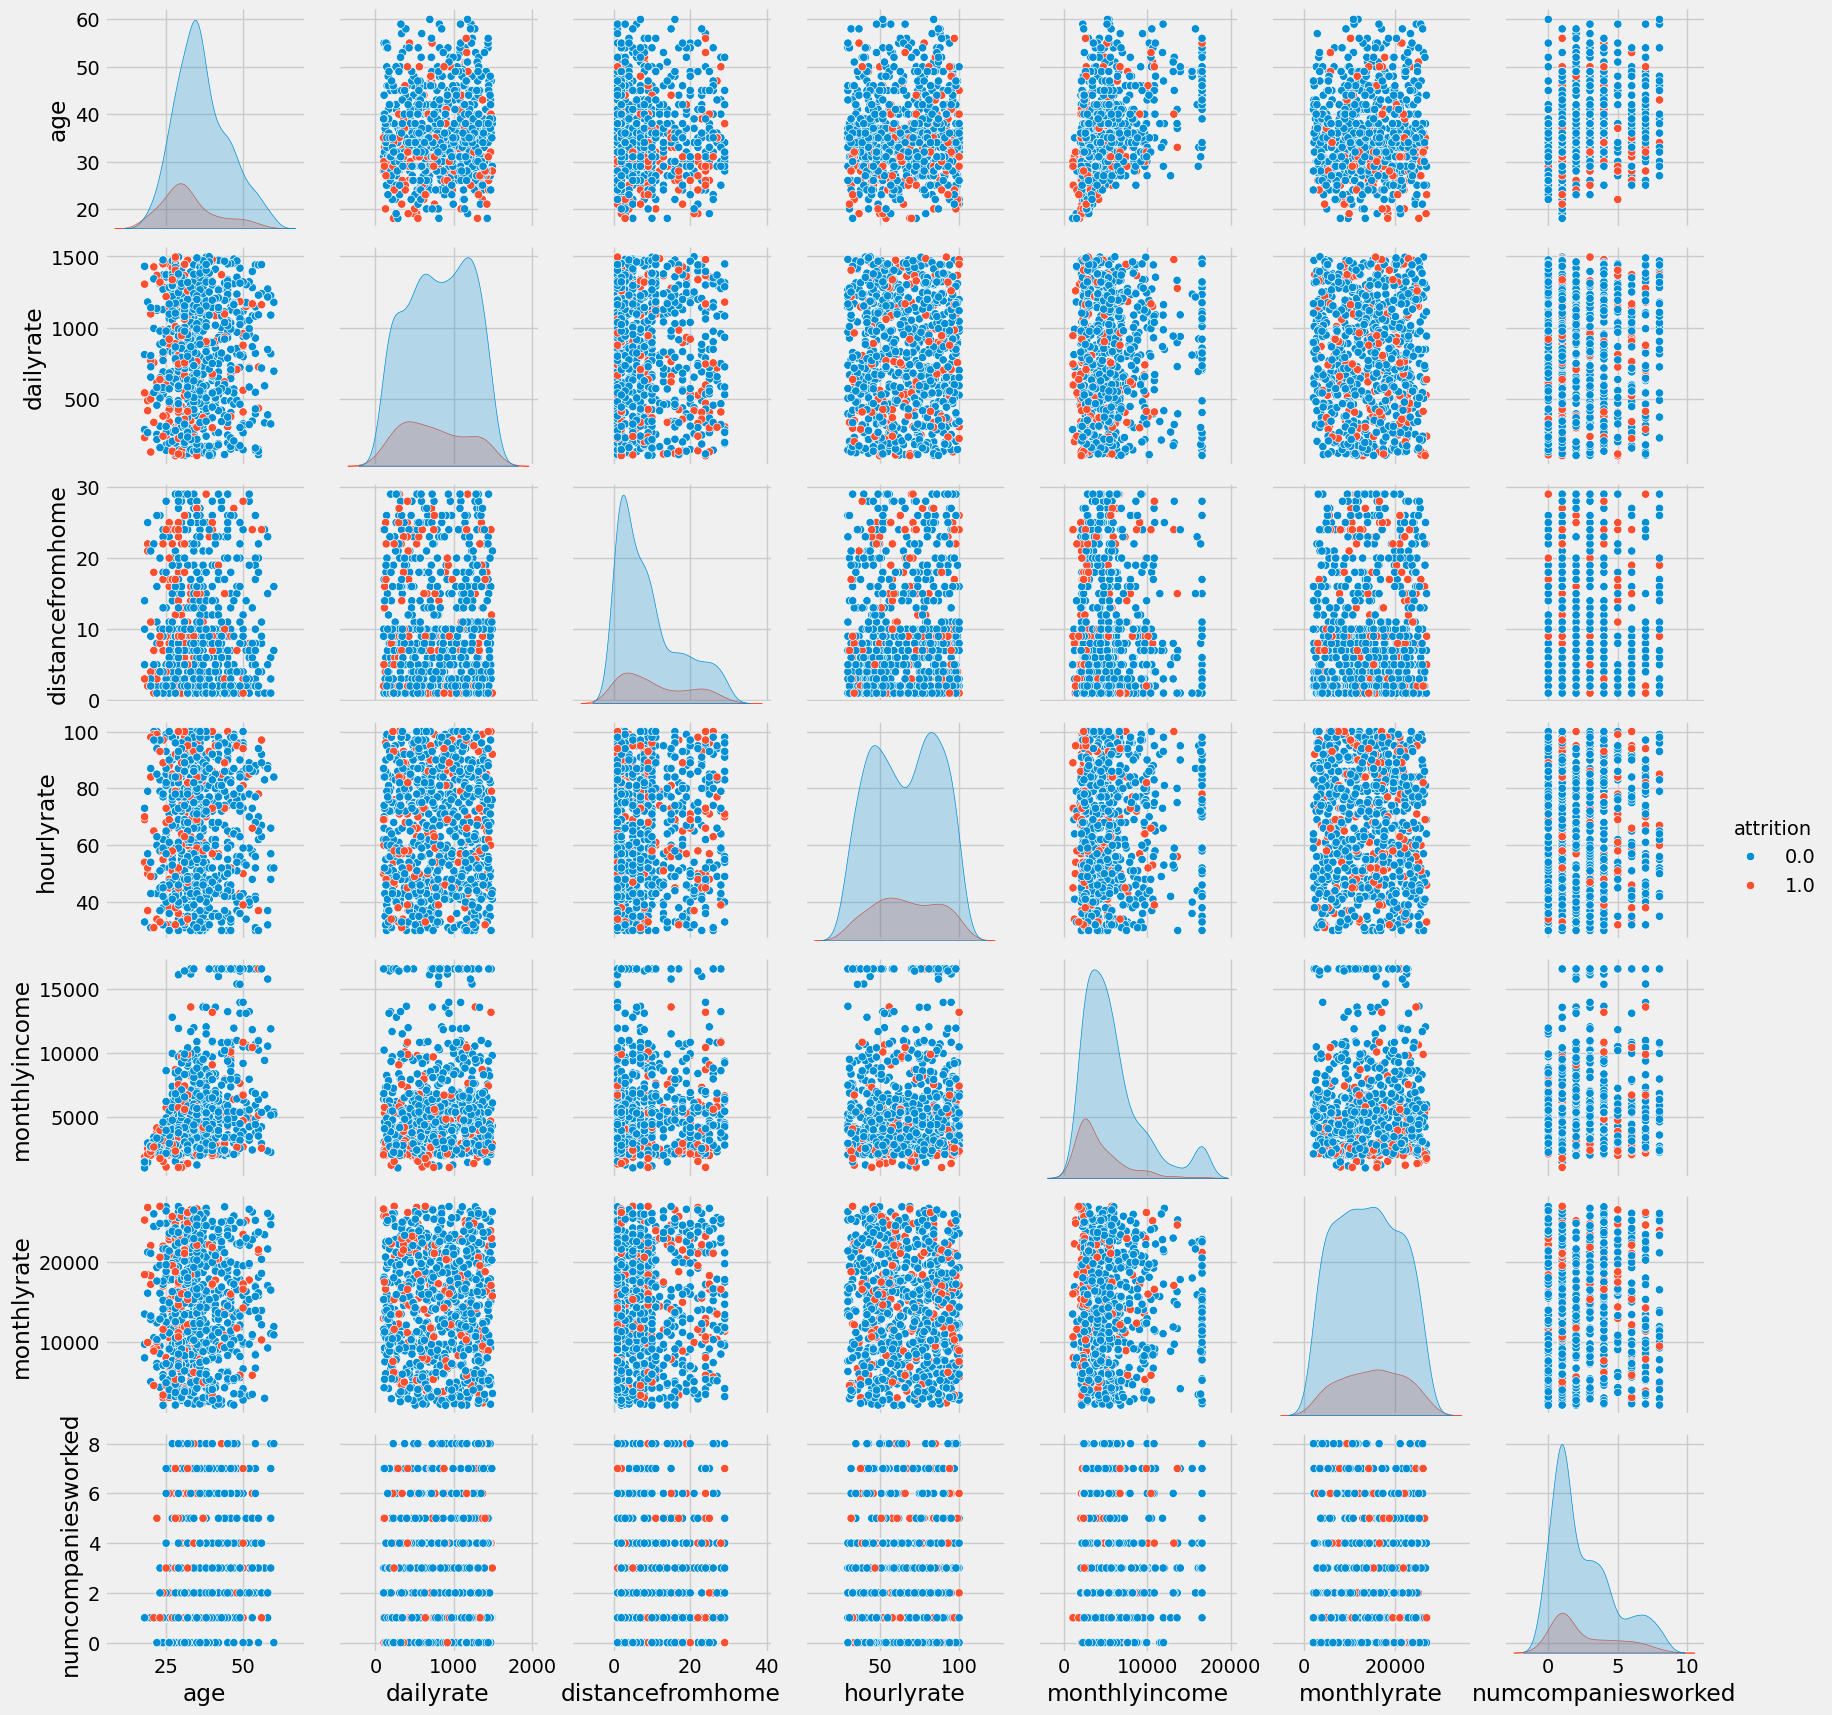

In [90]:
# Visualize a pairplot with relevant features
# YOUR CODE HERE
#sns.pairplot(df_emp, hue="attrition")

sns.set_context(font_scale=0.75, rc={"figure.figsize": (20, 20)})
subset = ['age','dailyrate',
 'distancefromhome',
 'hourlyrate',
 'monthlyincome',
 'monthlyrate', 'numcompaniesworked']

df_pairplot = pd.concat([df_newemp[subset], df_newemp['attrition']], axis=1)
sns.pairplot(df_pairplot, hue="attrition", height=2.5)



Inference from above plots - Age seems to have high corelation with Monthly Income. The rest of the plots are homogenous and have no significant correlation.

Further, Upon a quick check of correlations, we identified a few features which are significantly corelated (>0.4), and wanted to plot them

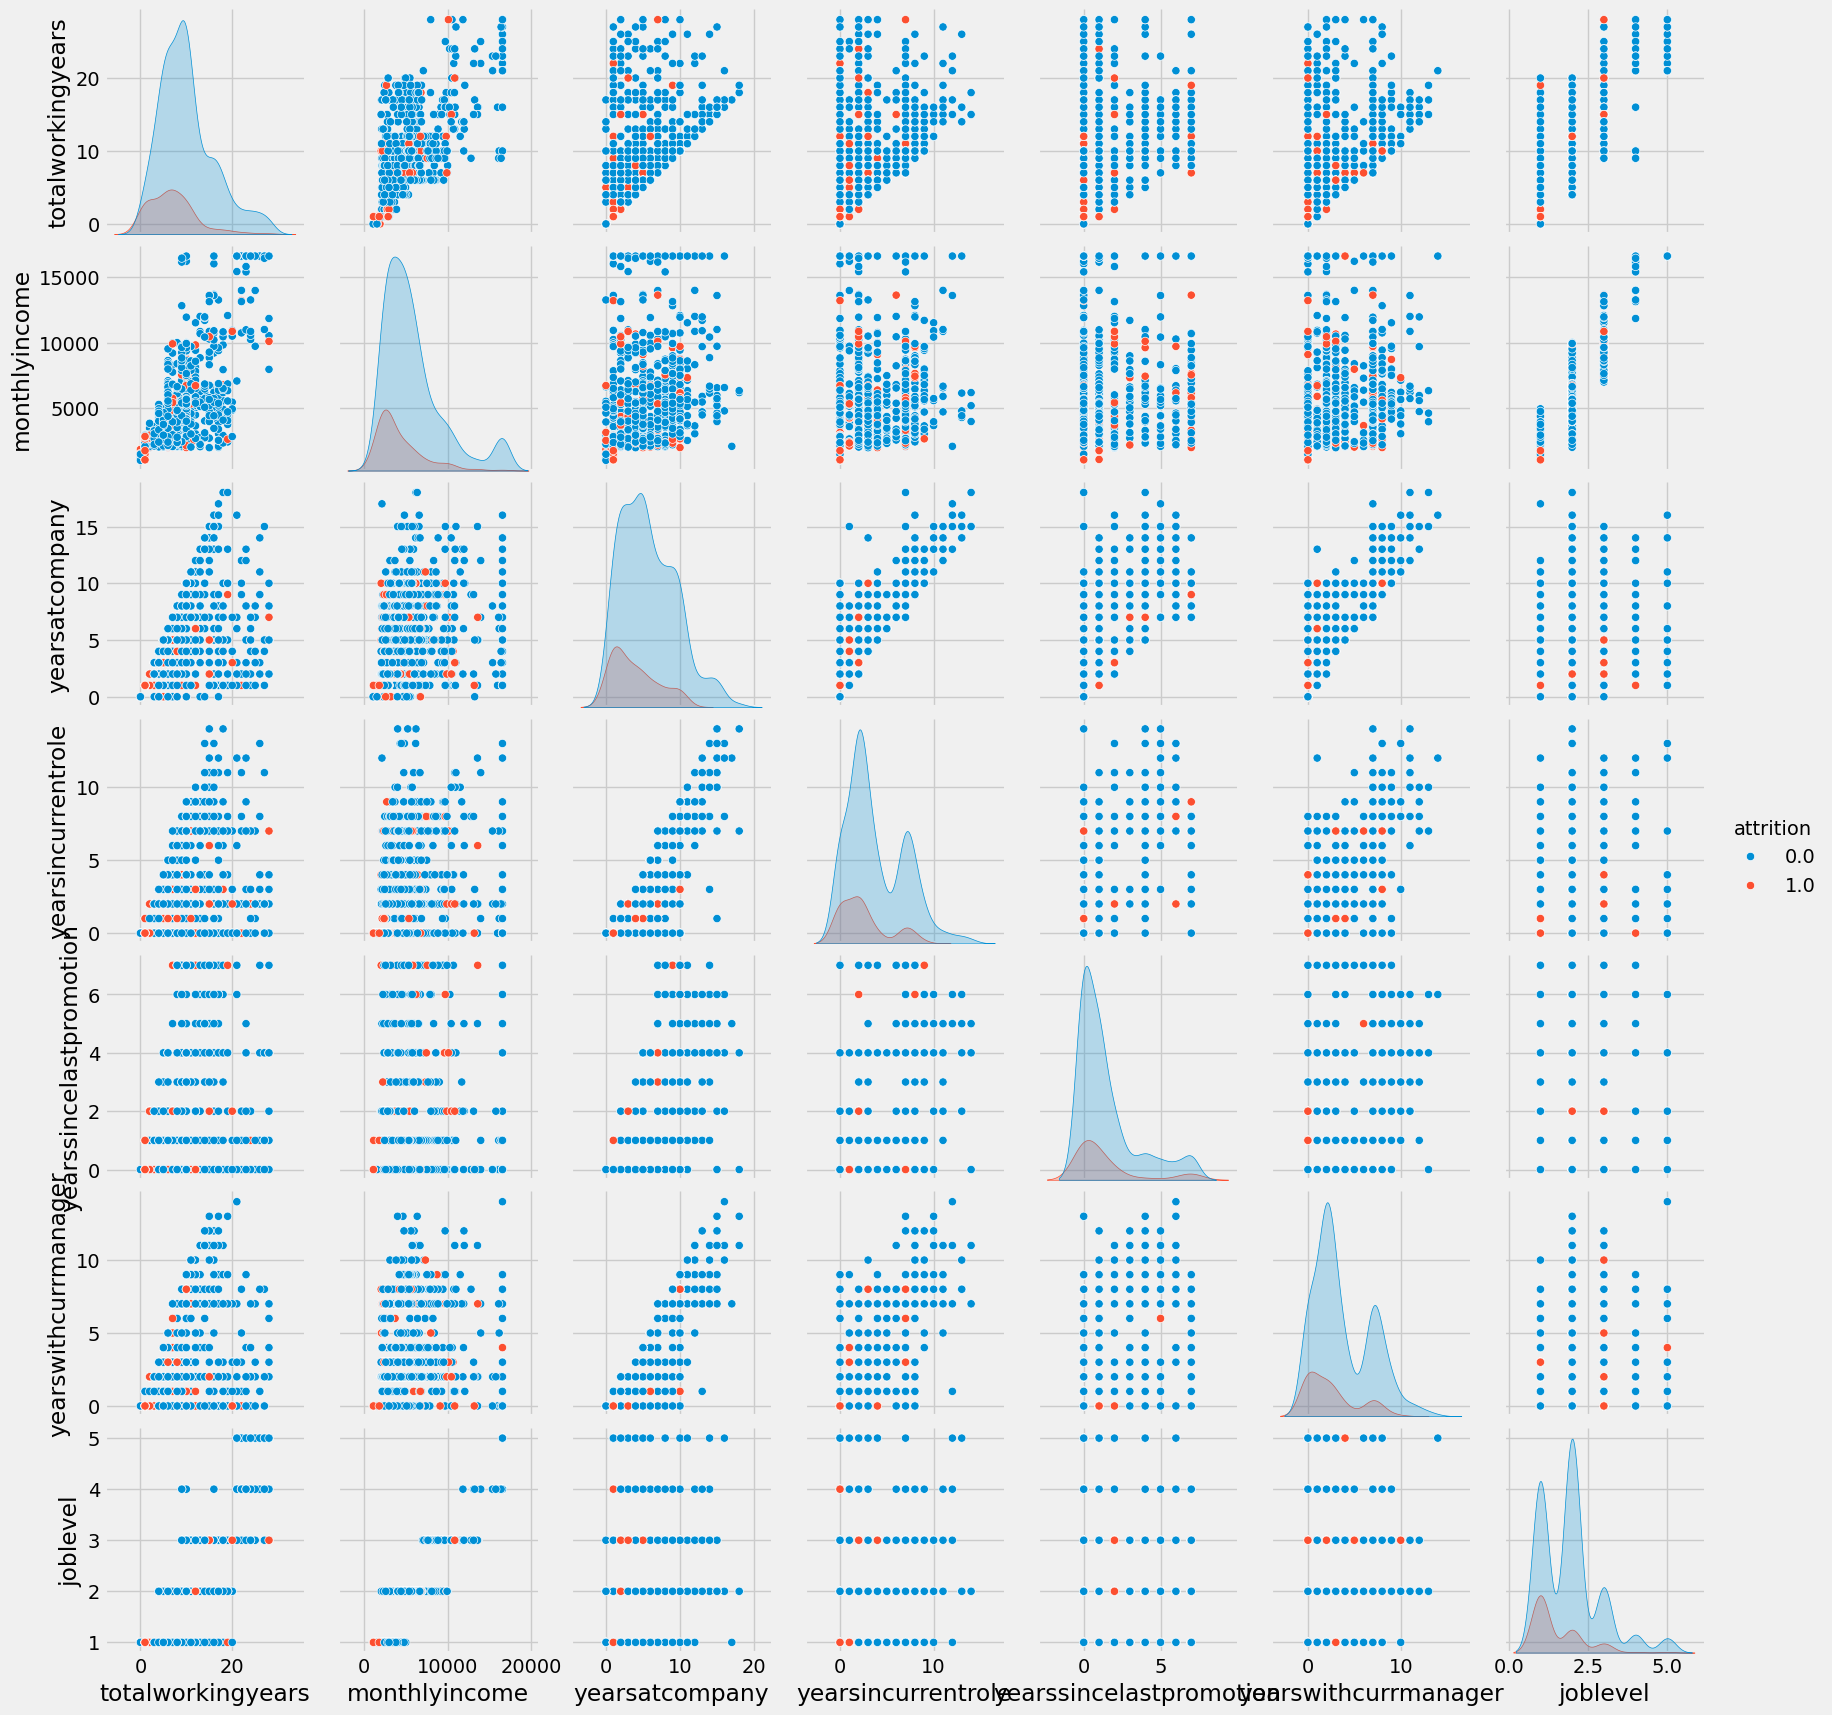

In [97]:
sns.set_context(font_scale=0.75, rc={"figure.figsize": (20, 20)})
subset = ['totalworkingyears',
 'monthlyincome',
 'yearsatcompany',
 'yearsincurrentrole',
 'yearssincelastpromotion',
 'yearswithcurrmanager', 'joblevel']

df_pairplot = pd.concat([df_newemp[subset], df_newemp['attrition']], axis=1)
sns.pairplot(df_pairplot, hue="attrition", height=2.5)

**From the above pairplots we can also see that the numerical features are all linearly inseparable as there are no clusters observed and a homogeneous distribution of the target class is observed.**

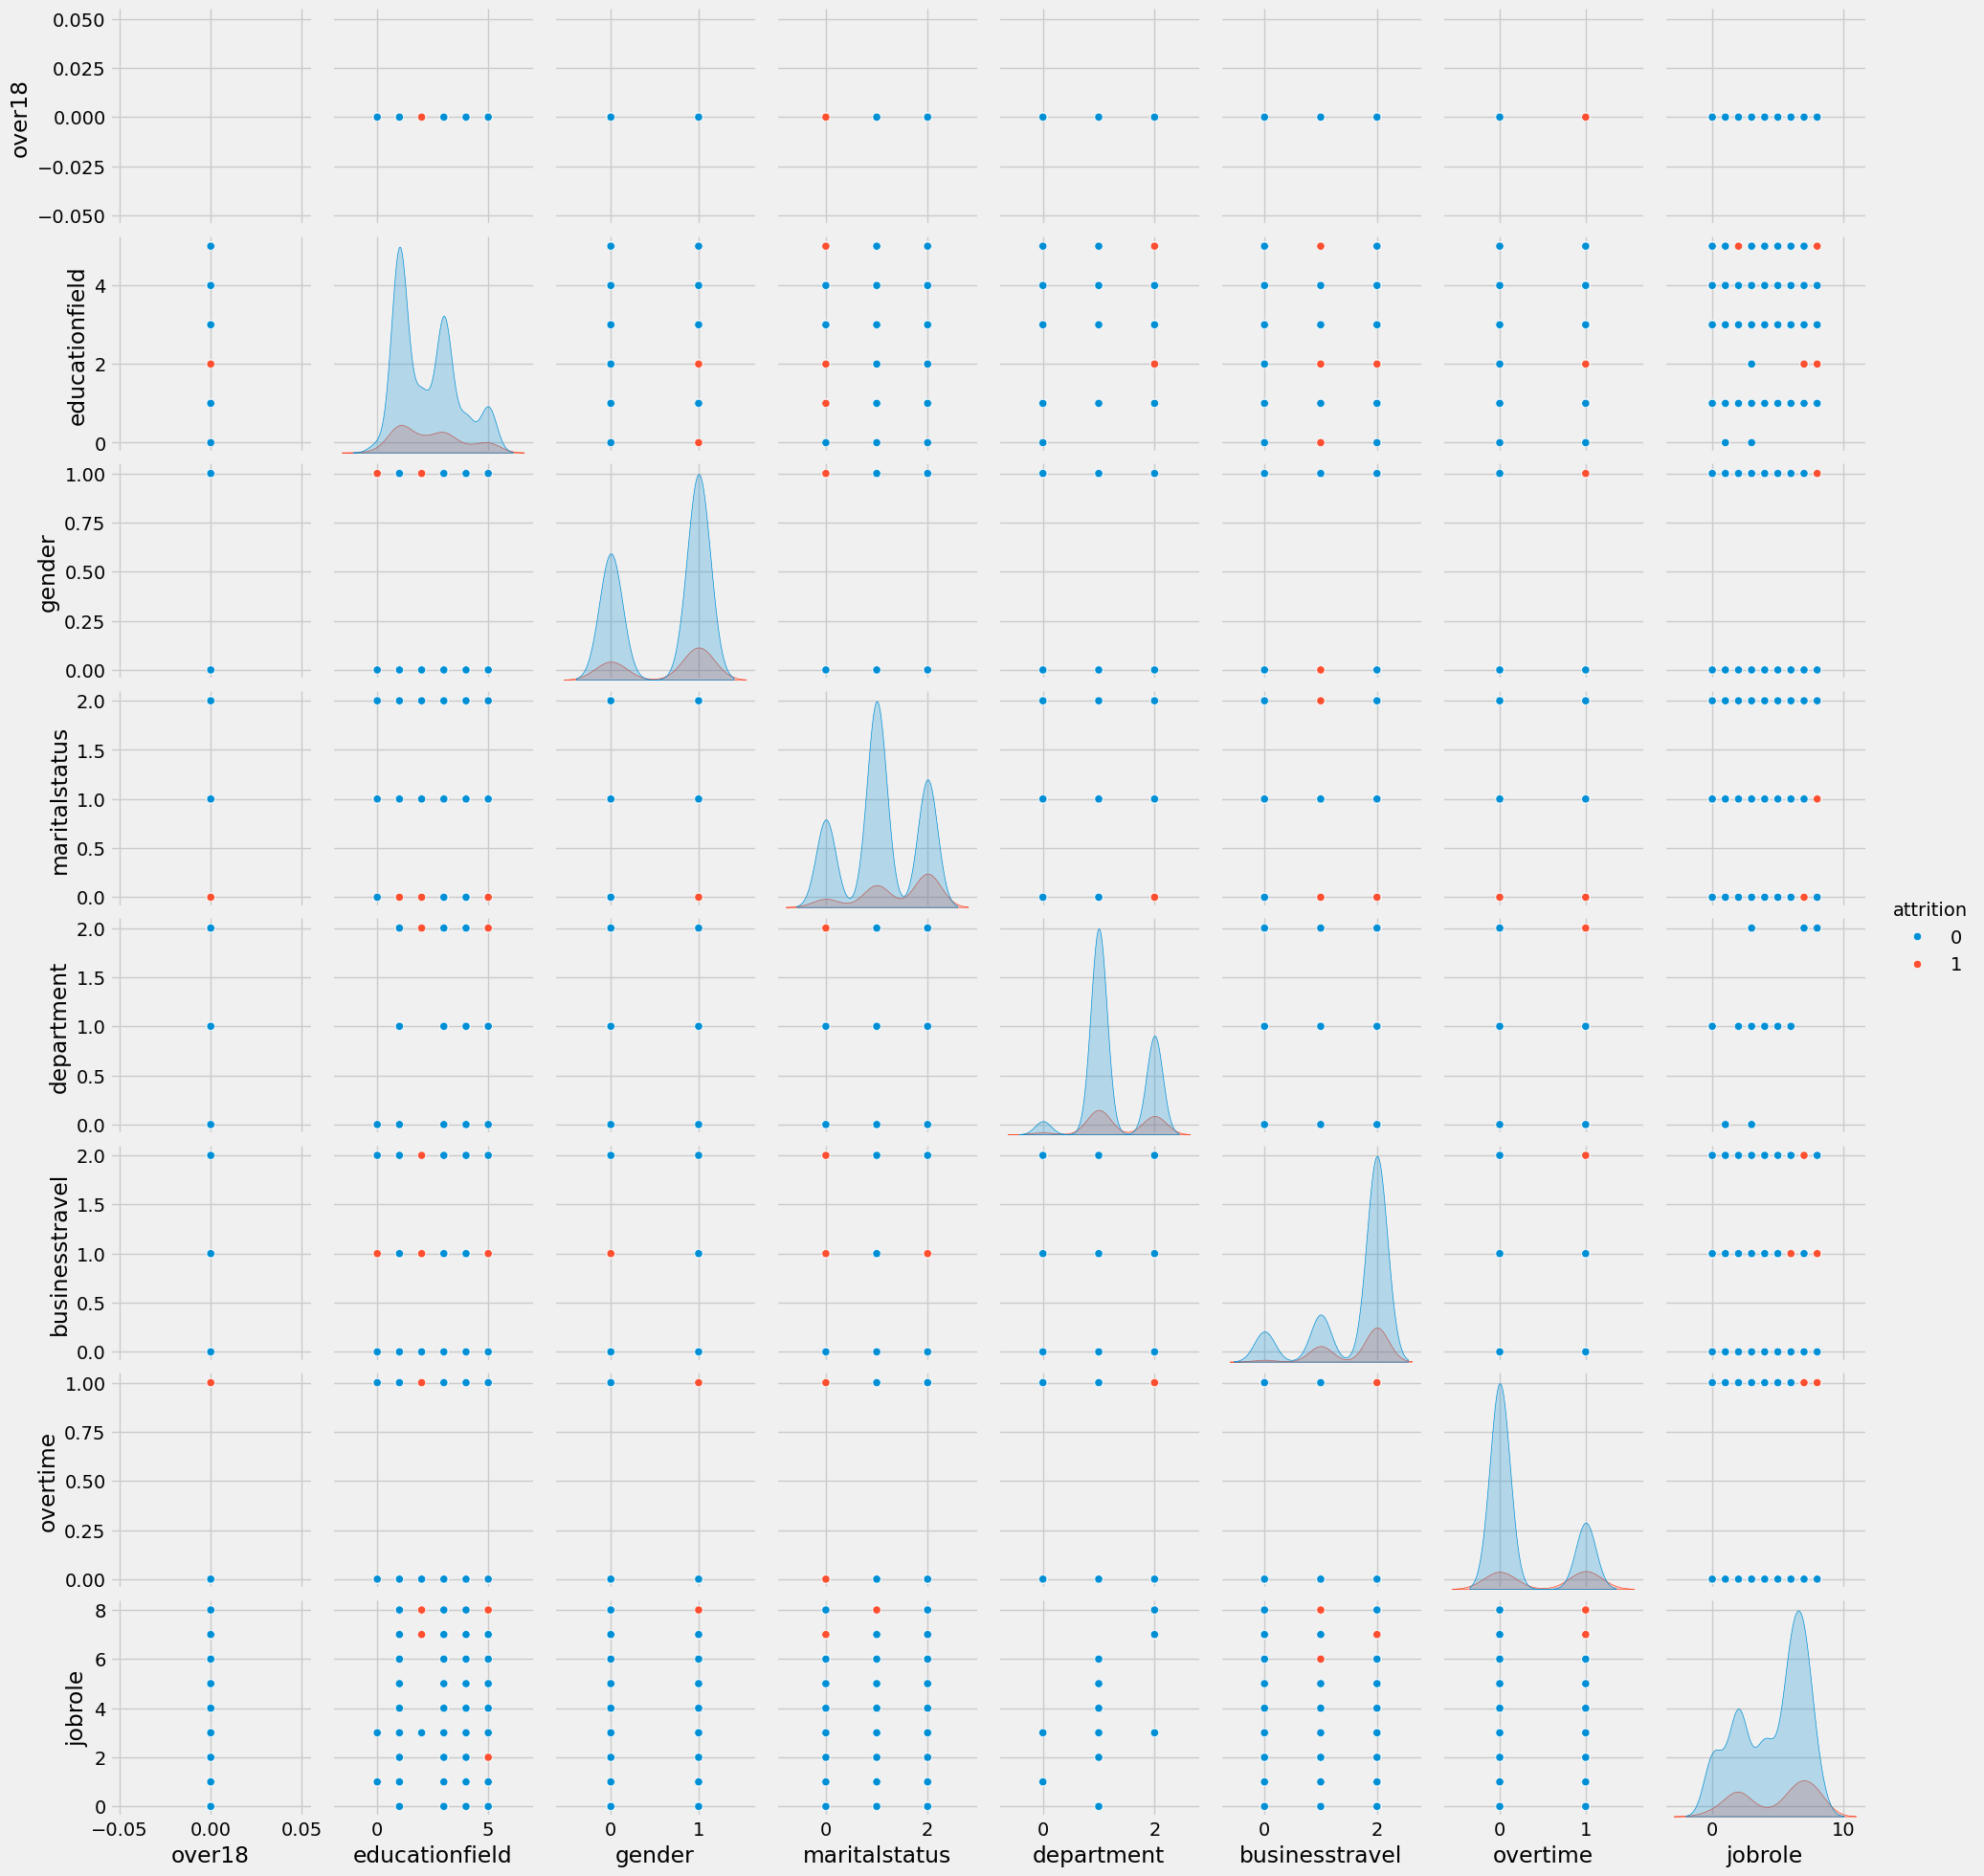

In [65]:
# Label encoding for categorical features

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
# Fit the encoder and transform the data

categ_cols = ['attrition', 'over18', 'educationfield', 'gender', 'maritalstatus', 'department', 'businesstravel', 'overtime', 'jobrole']
df_categ = df_newemp[categ_cols]
for col in categ_cols:
    df_categ[col] = le.fit_transform(df_categ[col])

df_categ.head()

sns.set_context(font_scale=0.75, rc={"figure.figsize": (20, 20)})

sns.pairplot(df_categ, hue="attrition", height=2.5)

In [ ]:
#sns.pairplot(
#    df_emp_clean,
#    #x_vars=[],
#    #y_vars=[],
#    vars = ["attrition","monthlyincome","yearsatcompany","yearsincurrentrole","yearswithcurrmanager","yearssincelastpromotion","percentsalaryhike","numcompaniesworked"]
#)

### Explore Correlation

- Plotting the Heatmap

**Exercise 7: Visualize the correlation among IBM employee attrition numerical features using a heatmap [0.5 Mark]**

<Axes: >

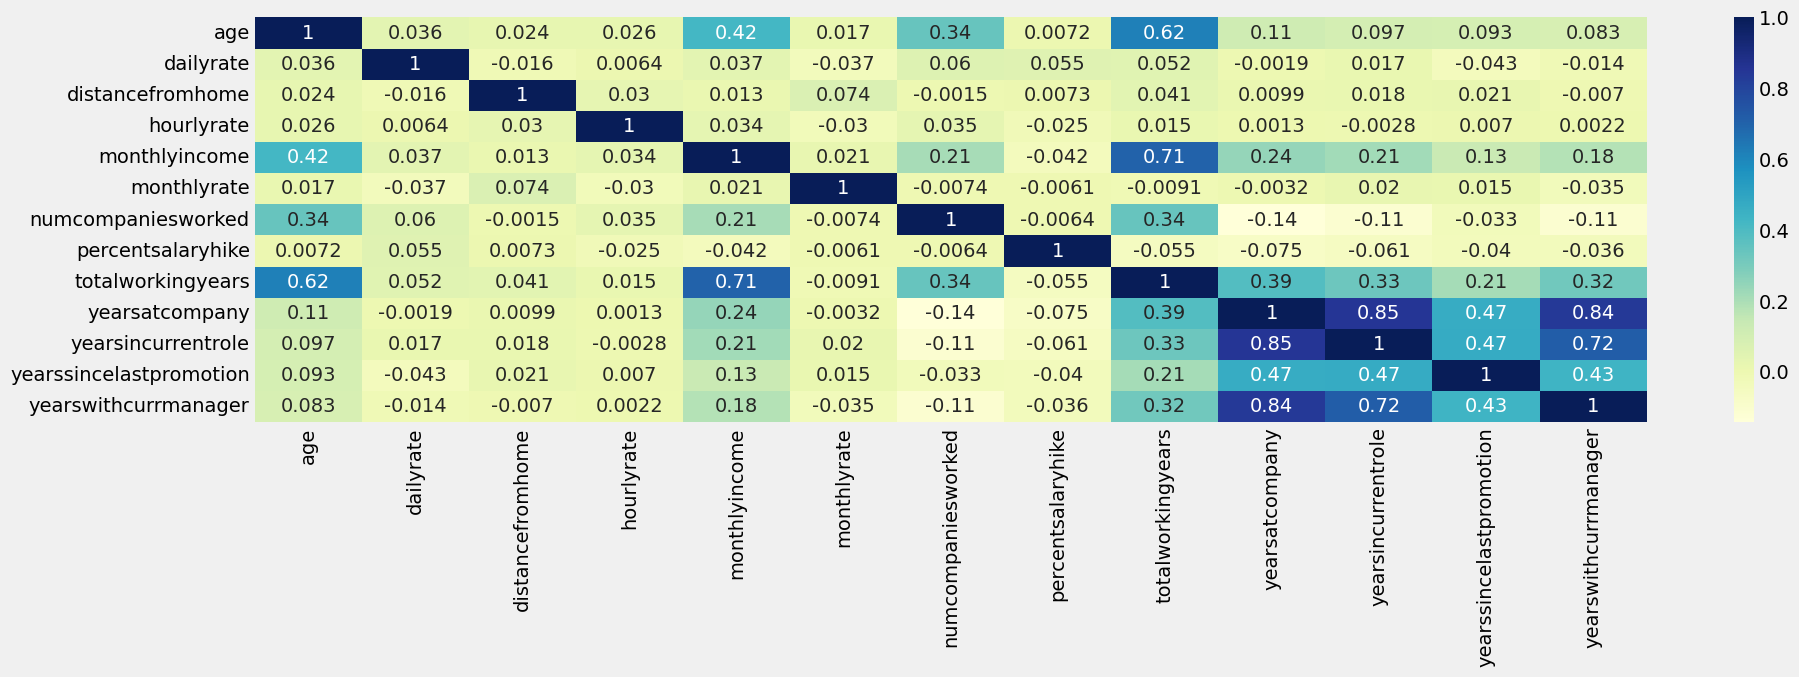

In [72]:
# Visualize heatmap
# YOUR CODE HERE

fig, ax = plt.subplots(figsize=(20,5))

subset = ['age','dailyrate',
 'distancefromhome',
 'hourlyrate',
 'monthlyincome',
 'monthlyrate',
 'numcompaniesworked',
 'percentsalaryhike','totalworkingyears', 'yearsatcompany', 'yearsincurrentrole', 'yearssincelastpromotion', 'yearswithcurrmanager']

data = df_newemp[subset].corr()
sns.set_context(font_scale=0.5)
sns.heatmap(data, cmap="YlGnBu", annot=True, ax=ax)

**From the above heat map, it is clearly seen that features like "yearsatcompany", "yearswithcurrmanager" are highly correlated and hence one of them can be dropped. Similarly, all others where high correlation is observed, features can be dropped.**

In [ ]:
data["yearsatcompany"].sort_values(ascending=True)

numcompaniesworked        -0.142724
percentsalaryhike         -0.074772
monthlyrate               -0.003215
dailyrate                 -0.001942
hourlyrate                 0.001329
distancefromhome           0.009937
age                        0.113804
monthlyincome              0.316020
totalworkingyears          0.386423
yearssincelastpromotion    0.467103
yearswithcurrmanager       0.838713
yearsincurrentrole         0.851831
yearsatcompany             1.000000
Name: yearsatcompany, dtype: float64

Comment on the observations made with the pairplot and heatmap

# Part-B

### Preparing the test feature space
* Remove outliers if any
* Handle the categorical feature if required
* Other processing steps can also be followed.

In [ ]:
# YOUR CODE HERE

Optional:
Use `Hyperopt`, a hyperparameter tuning technique to identify the best set of parameters.

In the notebook, data processing is done separately for different models.
Considering the fact that different models may require data in different format and in turn different processes may be followed to process the data.

If the processing steps followed for the models are same, data processing can also be done once.

## Apply CatBoost

Catboost was released in 2017 by Yandex, showing, by their benchmark to be faster in prediction, better in accuracy, and easier to use for categorical data across a series of GBDT tasks. Additional capabilities of catboost include plotting feature interactions and object (row) importance.

[Here](https://catboost.ai/en/docs/) is the official documentation of CatBoost

### Data Processing for CatBoost

**Exercise 8: Data processing for CatBoost [1 Mark]**
* **Copy the dataframe that was created after removing the outliers**
* **Handle the categorical features if required**
* **Create target column and feature space**

**Hint:** Column containing the information on attrition will be the target column.

In [ ]:
# Copy the data
# YOUR CODE HERE

In [ ]:
# Target Column
# YOUR CODE HERE

In [ ]:
# Feature Space
# YOUR CODE HERE

### Model Definition

**Exercise 9: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use CatBoostClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model. Refer [here](https://catboost.ai/en/docs/concepts/speed-up-training) to see some ways to speedup CatBoost training.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [ ]:
# Create CatBoost model
# YOUR CODE HERE

In [ ]:
# Model training
# YOUR CODE HERE

### Model performance

In [ ]:
# Model performance on all sets
# YOUR CODE HERE

## Apply XGBoost

XGBoost is a workhorse gradient boosted decision tree algorithm. Its been around since 2014 and has come to dominate the Kaggle and data science community. XGB introduced gradient boosting where new models are fit to the residuals of prior models and then added together, using a gradient descent algorithm to minimize the loss.

Read [here](https://xgboost.readthedocs.io/en/stable/parameter.html) on XGBoost parameters.

Refer [here](https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier) for the official documentation of XGBoost classifier.

### Data Processing for XGBoost


**Exercise 10: Data Processing for XGBoost [1 Mark]**
* **Copy the dataframe after the outliers were removed.**
* **Handle the categorical features if required**
* **Create target column and feature space**

In [ ]:
# Copy dataframe
# YOUR CODE HERE

**Hint:** Use pd.get_dummies

In [ ]:
# Handling categorical features
# YOUR CODE HERE

In [ ]:
# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

When creating the dummy variables, the name of attrition column was changed, rename to 'attrition' again.

**Hint:** Use .rename

In [ ]:
# Rename target column
# YOUR CODE HERE

In [ ]:
# Feature Space
# YOUR CODE HERE

# Targer label
# YOUR CODE HERE

### Model Definition

**Exercise 11: Define, train the model and display the results [2 Mark]**

**Hint:**
* Use XGBClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [ ]:
# Create XGBoost classifier model
# YOUR CODE HERE

In [ ]:
# Model training
# YOUR CODE HERE

### Model Performance

In [ ]:
# Model performance on all sets
# YOUR CODE HERE

## Apply LightGBM (Optional)

LightGBM is an open-source GBDT framework created by Microsoft as a fast and scalable alternative to XGB and GBM. By default LightGBM will train a Gradient Boosted Decision Tree (GBDT), but it also supports random forests, Dropouts meet Multiple Additive Regression Trees (DART), and Gradient Based One-Side Sampling (Goss).

To know more about LightGBM parameters, refer [here](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html#lightgbm.LGBMClassifier).

### Feature Engineering for LightGBM

In [ ]:
## Following the same procedure as followed in XGBoost

# Copy the dataframe
# YOUR CODE HERE

# Handling categorical features
# YOUR CODE HERE

# Concat the dummy variables to actual dataframe and remove initial categorical columns
# YOUR CODE HERE

# Rename target column
# YOUR CODE HERE

# Features Space
# YOUR CODE HERE

# Target Label
# YOUR CODE HERE

### Model Definition

**Hint:**
* Use LGBMClassifier() to define the model with relevant parameters.
* Use `fit` to fit the data to the model.
* Evaluate the model using roc_auc_score, accuracy_score, f1_score, predict methods or other relevant techniques.

In [ ]:
# Create LightGBM classifier model
# YOUR CODE HERE

In [ ]:
# Model training
# YOUR CODE HERE

### Model performance

In [ ]:
# Model performance on all sets
# YOUR CODE HERE

## Results

**Exercise 12: Create a dataframe of XGBoost results and CatBoost results and display them [0.5 Mark]**

**Hint:** Use pd.DataFrame

In [ ]:
# Create a dataframe for computed metrics for different models
# YOUR CODE HERE

Reference reading:
1. https://machinelearningmastery.com/xgboost-for-imbalanced-classification/